In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
    with sql.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sql.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [3]:
def show_tables():
    qt = '''select 
          name, type
        From sqlite_master
        where type IN ('table', 'view')'''
    return run_query(qt)

In [4]:
tables_views = show_tables()
tables_views

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [ ]:
del_view = '''drop view customer_country;'''
run_command(del_view)

In [6]:
q2 = '''with most_records_sold as(select g.name name, sum(il.quantity) records_sold from genre g
        inner join track t on g.genre_id = t.genre_id
        inner join invoice_line il on il.track_id = t.track_id
        inner join invoice i on il.invoice_id = i.invoice_id
        inner join customer c on i.customer_id = c.customer_id
        group by c.country, g.name
        having c.country = 'USA'
        order by sum(il.quantity) desc)
        select mrs.name genre, mrs.records_sold, (cast(mrs.records_sold as float) / (select sum(records_sold) from most_records_sold))*100 percentage from most_records_sold mrs;'''
most_records_sold_genre_usa = run_query(q2)
most_records_sold_genre_usa

,genre,records_sold,percentage
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


In [7]:
most_records_sold_genre_usa.set_index("genre", inplace=True, drop=True)

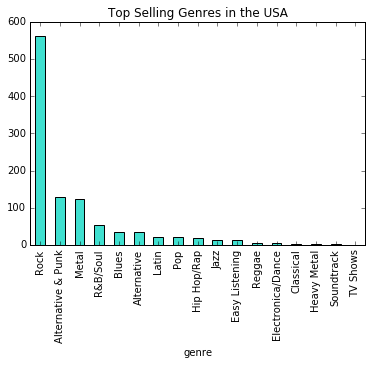

In [8]:
most_records_sold_genre_usa["records_sold"].plot.bar(
    title="Top Selling Genres in the USA", color= "turquoise")

From the above result we're able to infer that ROCK, Alternative & Punk, and Metal are the three most sold genre within united states. However, of the genere that record label is selling and based on the data we should select Punk, Blues and Pop albums as the first 3 albums to sold as a trial run.

Our next task is to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [9]:
q3 = '''With summary as (select e.employee_id, e.first_name||" "||e.last_name as employee, e.title, sum(i.total) total,
        e.hire_date from employee e
        left join customer c on e.employee_id = c.support_rep_id
        left join invoice i on c.customer_id = i.customer_id
        group by e.employee_id
        )
        select s.employee_id, s.employee, s.title,
        s.hire_date, ifnull(s.total, 0) total
        from summary s
        order by s.employee_id asc;'''
employee_performance = run_query(q3)
employee_performance

,employee_id,employee,title,hire_date,total
0,1,Andrew Adams,General Manager,2016-08-14 00:00:00,0.00
1,2,Nancy Edwards,Sales Manager,2016-05-01 00:00:00,0.00
2,3,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
3,4,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
4,5,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92
5,6,Michael Mitchell,IT Manager,2016-10-17 00:00:00,0.00
6,7,Robert King,IT Staff,2017-01-02 00:00:00,0.00
7,8,Laura Callahan,IT Staff,2017-03-04 00:00:00,0.00


In [10]:
employee_performance.set_index("title", inplace=True, drop=True)

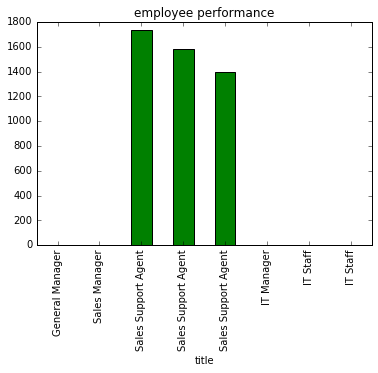

In [11]:
employee_performance["total"].plot.bar(title = "employee performance",\
                                       color = "green")

From the above result we can infer that we employee performance can not be measured by the amount of business they have done. We also have to take into account the role they are playing and the amount of time they have been working as a sales support agent.

in our next step we try to come up with a data table that collates data on purchases from different countries. For each country, include:
total number of customers,
total value of sales,
average value of sales per customer,
average order value.

In [12]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


In [13]:
import numpy as np
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

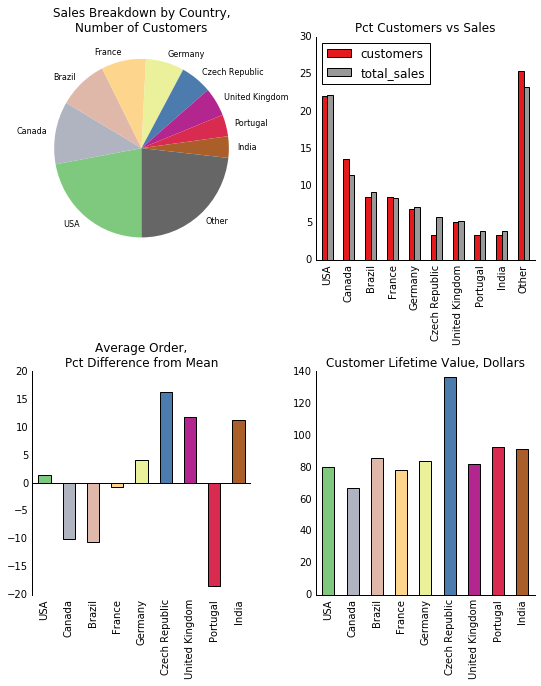

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:
* Czech Republic
* United Kingdom
* India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

In [31]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.